In [8]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture as GM
import scipy.stats as ss

In [9]:

n = 10000

def GM_Sample(n) :
    norm_params = np.array([[-2, 0.5],
                            [0.5, 0.8],])
    n_components = norm_params.shape[0]
    weights = np.ones(n_components, dtype=np.float64) / 2.0
    mixture_idx = np.random.choice(len(weights),
                                   size=n,
                                   replace=True, 
                                   p=weights)
    # y is the mixture sample
    y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                       dtype=np.float64)
    xs = np.linspace(y.min(), y.max(), n)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, weights):
        ys += ss.norm.pdf(xs, loc=l, scale=s) * w
    y = MinMaxScaler(feature_range=(-1,1)).fit_transform(y.reshape(-1,1))
    y = y.reshape(1,-1)[0]
    ys = MinMaxScaler(feature_range=(-1,1)).fit_transform(ys.reshape(-1,1))
    ys = ys.reshape(1,-1)[0]
    return y , ys

In [10]:
#MinMaxScaler().fit_transform(y)[0]

In [11]:
#bimodal_mixmax = MinMaxScaler().fit(y.reshape(-1,1))
y , ys = GM_Sample(10000)

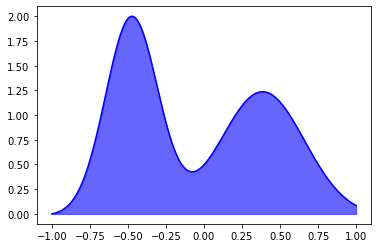

In [12]:
x_vals = np.linspace(-1, 1, 301)
y_s , y_vals = GM_Sample(len(x_vals))
#y_vals = stats.norm(0,1).pdf(x_vals)
plt.plot(x_vals, y_vals + 1, color='blue', label='real')
plt.fill_between(x_vals, np.zeros(len(x_vals)), y_vals+1, color='blue', alpha=0.6)

(array([41., 25., 53., 35., 32., 42., 29.,  9., 11., 24.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

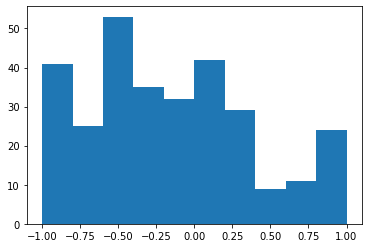

In [13]:
plt.hist(y_vals)

In [14]:
# grid_latent = np.linspace(-1, 1, 103)[1:-1].reshape((-1, 1))
# true_mappings = uniform_to_normal(grid_latent)
# plt.hist(true_mappings)

In [15]:
NUM_BATCHES = 1000
BATCH_SIZE = 512
PLOT_EVERY = 1
GRID_RESOLUTION = 400
LATENT_DIM = 1

def uniform_to_normal(z):
    '''
    Map a value from ~U(-1, 1) to ~N(0, 1)
    '''
    norm = stats.norm(0, 1)
    return norm.ppf((z+1)/2)

def generate_noise(samples, dimensions=2):
    '''
    Generate a matrix of random noise in [-1, 1] with shape (samples, dimensions) 
    '''
    return np.random.uniform(-1, 1, (samples, dimensions))


def build_generator(LATENT_DIM, output_dim):
    '''
    Build a generator mapping (R, R) to ([-1,1], [-1,1])
    '''
    input_layer = layers.Input((LATENT_DIM,))
    X = input_layer
    for i in range(4):
        X = layers.Dense(16)(X)
        X = layers.LeakyReLU(0.1)(X)
    output_layer = layers.Dense(output_dim ,  activation='tanh')(X)
    G = Model(input_layer, output_layer)
    return G


def build_discriminator(dim):
    '''
    Build a discriminator mapping (R, R) to [0, 1]
    '''
    input_layer = layers.Input((dim,))
    X = input_layer
    for i in range(2):
        X = layers.Dense(64)(X)
        X = layers.LeakyReLU(0.1)(X)
    output_layer = layers.Dense(1, activation='sigmoid')(X)
    D = Model(input_layer, output_layer)
    D.compile(Adam(learning_rate=0.002, beta_1=0.5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    return D

def build_GAN(G, D, LATENT_DIM):
    '''
    Given a generator and a discriminator, build a GAN
    '''
    D.trainable = False
    input_layer = layers.Input((LATENT_DIM,))
    X = G(input_layer)
    output_layer = D(X)
    GAN = Model(input_layer, output_layer)
    GAN.compile(Adam(learning_rate=0.001, beta_1=0.5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    return GAN

def plot(G, D, step, step_count, D_accuracy, D_loss, G_accuracy, G_loss, filename):
    '''
    Plots for the GAN gif
    '''
    f, ax = plt.subplots(2, 2, figsize=(8,8))
    f.suptitle(f'\n       {step:05d}', fontsize=10)


    # [0, 0]: plot loss and accuracy
    ax[0, 0].plot(step_count, 
                    G_loss,
                    label='G loss',
                    c='darkred',
                    zorder=50,
                    alpha=0.8,)
    ax[0, 0].plot(step_count, 
                    G_accuracy,
                    label='G accuracy',
                    c='lightcoral',
                    zorder=40,
                    alpha=0.8,)
    ax[0, 0].plot(step_count, 
                    D_loss,
                    label='D loss',
                    c='darkblue',
                    zorder=55,
                    alpha=0.8,)
    ax[0, 0].plot(step_count, 
                    D_accuracy,
                    label='D accuracy',
                    c='cornflowerblue',
                    zorder=45,
                    alpha=0.8,)
    ax[0, 0].set_xlim(-5, max(max(step_count), NUM_BATCHES)+5)
    ax[0, 0].set_ylim(-0.05, 1.55)
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].legend(loc=1)

    # [0, 1]: Plot actual samples and fake samples

    
    #sns.kdeplot(test_samples.flatten(), c='blue', alpha=0.6, label='Real', ax=ax[0, 1], shade=True)
    
    x_vals = np.linspace(-1, 1, 301)
    y_s , y_vals = GM_Sample(len(x_vals))
    fake_samples = G.predict(test_noise, batch_size=len(x_vals))
    #y_vals = stats.norm(0,1).pdf(x_vals)
    ax[0, 1].plot(x_vals, y_vals  + 1 , color='blue', label='real')
    ax[0, 1].fill_between(x_vals, np.zeros(len(x_vals)), y_vals  + 1, color='blue', alpha=0.6)
    #sns.kdeplot(test_samples.flatten(), c='blue', alpha=0.6, label='Real', ax=ax[0, 1], shade=True)
    sns.kdeplot(fake_samples.flatten(), c='red', alpha=0.6, label='GAN', ax=ax[0, 1], shade=True)
    ax[0, 1].set_xlim(-1, 1)
    #ax[0, 1].set_ylim(0, 0.82)
    ax[0, 1].legend(loc=1)
    ax[0, 1].set_xlabel('Sample Space')
    ax[0, 1].set_ylabel('Probability Density')


    # [1, 0]: Confident real input
    grid_latent = np.linspace(-1, 1, 300)[1:-1].reshape((-1, 1))
    #true_mappings = uniform_to_normal(grid_latent)
    y_s , true_mappings = GM_Sample(len(grid_latent))
    GAN_mapping = G.predict(grid_latent)
    ax[1, 0].scatter(grid_latent.flatten(), true_mappings.flatten(), 
                edgecolor='blue', facecolor='None', s=5, alpha=1, 
                linewidth=1, label='Real Mapping')
    ax[1, 0].scatter(grid_latent.flatten(), GAN_mapping.flatten(), 
                edgecolor='red', facecolor='None', s=5, alpha=1, 
                linewidth=1, label='GAN Mapping')
    ax[1, 0].legend(loc=8)
    ax[1, 0].set_xlim(-1, 1)
    ax[1, 0].set_ylim(-3, 3)
    ax[1, 0].set_xlabel('Latent Space')
    ax[1, 0].set_ylabel('Sample Space')

    # [1, 1]: Confident real ouput
    confidences = D.predict(grid_sample, batch_size=BATCH_SIZE).flatten()
    ax[1, 1].plot(grid_sample.flatten(), confidences, c='k')
    lower, upper = -1, 1
    for i in range(0, len(confidences), 50):
        if i ==0:
            continue
        ax[1, 1].plot([i / len(confidences) * (upper - lower) + lower, ]*2,
                        [0, confidences[i]], c='k')
    ax[1, 1].plot([lower, lower, upper, upper], [confidences[0], 0, 0, confidences[-1]], c='k')
    ax[1, 1].fill_between(grid_sample.flatten(), np.zeros(len(confidences)), confidences, color='k', alpha=0.6)
    ax[1, 1].set_xlabel('Sample Space Value')
    ax[1, 1].set_ylabel('Discriminator Confidence')
    ax[1, 1].set_xlim(lower, upper)
    ax[1, 1].set_ylim(-0.00, 1.00)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    return


In [16]:
LATENT_DIM

1

In [17]:
### Visualizations
grid_latent = np.linspace(-1, 1, 203)[1:-1].reshape((-1, 1))
grid_sample = np.linspace(-3, 3, 603)[1:-1].reshape((-1, 1))
test_noise = generate_noise(5000, LATENT_DIM)
test_samples = uniform_to_normal(test_noise)


## Set up directories
paths = ['ims', 
            'ims/1_1D_normal', 
                'ims/1_1D_normal/a', 
                'ims/1_1D_normal/b', 
                'ims/1_1D_normal/c', 
        ]
for i in paths:
    if not os.path.exists(i):
        os.makedirs(i)

## Part 1b: 1D uniform to 1D normal GAN
### Setup

test_noise = generate_noise(1000, LATENT_DIM)
test_samples = uniform_to_normal(test_noise)
G = build_generator(LATENT_DIM, 1)
D = build_discriminator(1)
GAN = build_GAN(G, D, LATENT_DIM)

W0116 12:58:04.414521 140184542459648 deprecation.py:506] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0116 12:58:04.624817 140184542459648 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/root/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


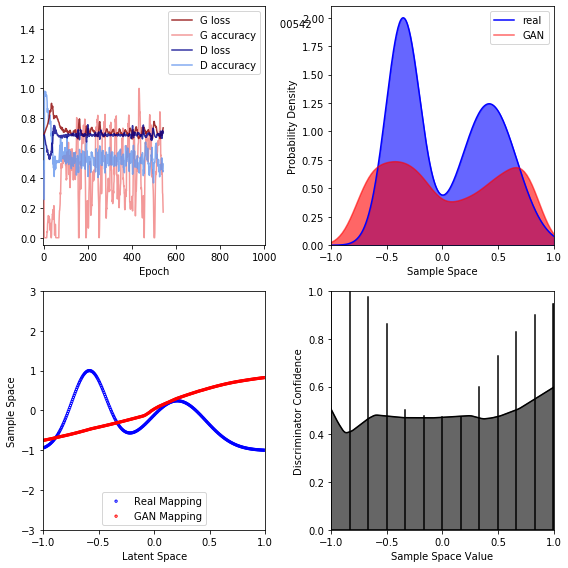

/root/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


In [ ]:
step_count = []
D_accuracy = []
G_accuracy = []
D_loss = []
G_loss = []
count = 0
for step in range(NUM_BATCHES):
    print(f'1b: {step}/{NUM_BATCHES}', end='\r')
    # Train discriminator
    D.trainable = True
    real_data , ys  = GM_Sample(BATCH_SIZE // 2)
    real_data = real_data.reshape(-1,1)
    #real_data
    #real_data = uniform_to_normal(generate_noise(BATCH_SIZE // 2, LATENT_DIM))
    fake_data = G.predict(generate_noise(BATCH_SIZE // 2, LATENT_DIM), batch_size=BATCH_SIZE // 2)
    data = np.concatenate((real_data, fake_data), axis=0)
    real_labels = np.ones((BATCH_SIZE // 2, 1))
    fake_labels = np.zeros((BATCH_SIZE // 2, 1))
    labels = np.concatenate((real_labels, fake_labels), axis=0)
    _D_loss, _D_accuracy = D.train_on_batch(data, labels)

    # Train generator
    D.trainable = False
    noise = generate_noise(BATCH_SIZE, LATENT_DIM)
    labels = np.ones((BATCH_SIZE, 1))
    _G_loss, _G_accuracy = GAN.train_on_batch(noise, labels)
    
    if step % PLOT_EVERY == 0:
        step_count.append(step)
        D_loss.append(_D_loss)
        D_accuracy.append(_D_accuracy)
        G_loss.append(_G_loss)
        G_accuracy.append(_G_accuracy)
        plot(G=G, 
             D=D,
             step=step+1,
             step_count=step_count,
             D_accuracy=D_accuracy,
             D_loss=D_loss,
             G_accuracy=G_accuracy,
             G_loss=G_loss,
             filename=f'ims/1_1D_normal/b/1b.{count:04d}.png')
        count += 1
    if step % 10 == 0 :
        clear_output()
print()


In [ ]:
os.system(f'ffmpeg -r 20 -i ims/1_1D_normal/b/1b.%04d.png'
              f' -crf 15 ims/1_1D_normal/1b.mp4')

In [ ]:
total_steps = 30000
for step in range(NUM_BATCHES, total_steps):
    print(f'1c: {step}/{total_steps}', end='\r')
    # Train discriminator
    D.trainable = True
    real_data = uniform_to_normal(generate_noise(BATCH_SIZE // 2, LATENT_DIM))
    fake_data = G.predict(generate_noise(BATCH_SIZE // 2, LATENT_DIM), batch_size=BATCH_SIZE // 2)
    data = np.concatenate((real_data, fake_data), axis=0)
    real_labels = np.ones((BATCH_SIZE // 2, 1))
    fake_labels = np.zeros((BATCH_SIZE // 2, 1))
    labels = np.concatenate((real_labels, fake_labels), axis=0)
    _D_loss, _D_accuracy = D.train_on_batch(data, labels)

    # Train generator
    D.trainable = False
    noise = generate_noise(BATCH_SIZE, LATENT_DIM)
    labels = np.ones((BATCH_SIZE, 1))
    _G_loss, _G_accuracy = GAN.train_on_batch(noise, labels)

    if step % PLOT_EVERY == 0:
        step_count.append(step)
        D_loss.append(_D_loss)
        D_accuracy.append(_D_accuracy)
        G_loss.append(_G_loss)
        G_accuracy.append(_G_accuracy)

plot(G=G, 
     D=D,
     step=step+1,
     step_count=step_count,
     D_accuracy=D_accuracy,
     D_loss=D_loss,
     G_accuracy=G_accuracy,
     G_loss=G_loss,
     filename=f'ims/1_1D_normal/c/1c.{total_steps:03d}.png')

In [ ]:
G.save("ims/1_1D_normal/c/G.h5")
D.save("ims/1_1D_normal/c/D.h5")

grid_latent = np.linspace(-1, 1, 103)[1:-1].reshape((-1, 1))
true_mappings = uniform_to_normal(grid_latent)
GAN_mapping = G.predict(grid_latent)

plt.figure(figsize=(6,6))
plt.scatter(grid_latent.flatten(), true_mappings.flatten(), 
            edgecolor='blue', facecolor='None', s=5, alpha=1, 
            linewidth=1, label='Inverse CDF Mapping')
plt.scatter(grid_latent.flatten(), GAN_mapping.flatten(), 
            edgecolor='red', facecolor='None', s=5, alpha=1, 
            linewidth=1, label='Inverse CDF Mapping')
plt.xlim(-1, 1)
plt.ylim(-4, 4)
plt.tight_layout()
plt.savefig(f'ims/1_1D_normal/c/1c.true.png')
plt.close()